# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1040s2"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1380, 32, 20, 3)
(1380, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
345/345 [==============================] - 3s 6ms/step - loss: 2.0857 - accuracy: 0.3600
Epoch 2/500
345/345 [==============================] - 2s 6ms/step - loss: 1.3651 - accuracy: 0.5677
Epoch 3/500
345/345 [==============================] - 2s 6ms/step - loss: 0.9522 - accuracy: 0.6930
Epoch 4/500
345/345 [==============================] - 3s 7ms/step - loss: 0.8026 - accuracy: 0.7475: 0s - loss: 0.8024 - accuracy: 
Epoch 5/500
345/345 [==============================] - 3s 8ms/step - loss: 0.6888 - accuracy: 0.7754
Epoch 6/500
345/345 [==============================] - 3s 8ms/step - loss: 0.6854 - accuracy: 0.7918
Epoch 7/500
345/345 [==============================] - 3s 8ms/step - loss: 0.5705 - accuracy: 0.8056
Epoch 8/500
345/345 [==============================] - 3s 8ms/step - loss: 0.5233 - accuracy: 0.8428
Epoch 9/500
345/345 [==============================] - 3s 9ms/step - loss: 0.4905 - accuracy: 0.8644: 0s - loss: 0.4845 - 
Epoch 10/500
345/345 [===============

345/345 [==============================] - 5s 13ms/step - loss: 0.1004 - accuracy: 0.9726
Epoch 79/500
345/345 [==============================] - 4s 12ms/step - loss: 0.1231 - accuracy: 0.9634
Epoch 80/500
345/345 [==============================] - 4s 12ms/step - loss: 0.1328 - accuracy: 0.9632 0s - loss: 0
Epoch 81/500
345/345 [==============================] - 4s 13ms/step - loss: 0.1187 - accuracy: 0.9596
Epoch 82/500
345/345 [==============================] - 4s 12ms/step - loss: 0.0842 - accuracy: 0.9714
Epoch 83/500
345/345 [==============================] - 4s 10ms/step - loss: 0.0958 - accuracy: 0.9750
Epoch 84/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0990 - accuracy: 0.9656
Epoch 85/500
345/345 [==============================] - 4s 10ms/step - loss: 0.0821 - accuracy: 0.9770
Epoch 86/500
345/345 [==============================] - 4s 10ms/step - loss: 0.1147 - accuracy: 0.9666
Epoch 87/500
345/345 [==============================] - 4s 11ms/step - lo

345/345 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - 4s 10ms/step - loss: 0.0825 - accuracy: 0.9797
Epoch 157/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0566 - accuracy: 0.9848
Epoch 158/500
345/345 [==============================] - 3s 10ms/step - loss: 0.0520 - accuracy: 0.9785
Epoch 159/500
345/345 [==============================] - 3s 10ms/step - loss: 0.0452 - accuracy: 0.9865
Epoch 160/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0326 - accuracy: 0.9911
Epoch 161/500
345/345 [==============================] - 4s 10ms/step - loss: 0.0303 - accuracy: 0.9943 0s - loss: 0.0263 - 
Epoch 162/500
345/345 [==============================] - 3s 10ms/step - loss: 0.0490 - accuracy: 0.9850
Epoch 163/500
345/345 [==============================] - 4s 10ms/step - loss: 0.0881 - accuracy: 0.9728
Epoch 164/500
345/345 [==============================] - 4s 10ms/step - loss: 0.0734 - accuracy: 0.9798
Epoch 165/500
3

345/345 [==============================] - 3s 10ms/step - loss: 0.0202 - accuracy: 0.9915
Epoch 234/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0444 - accuracy: 0.9855
Epoch 235/500
345/345 [==============================] - 4s 10ms/step - loss: 0.0592 - accuracy: 0.9760
Epoch 236/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0960 - accuracy: 0.9835
Epoch 237/500
345/345 [==============================] - 4s 10ms/step - loss: 0.0684 - accuracy: 0.9846 0s - loss: 0
Epoch 238/500
345/345 [==============================] - 3s 10ms/step - loss: 0.0451 - accuracy: 0.9856
Epoch 239/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0600 - accuracy: 0.9811
Epoch 240/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0660 - accuracy: 0.9837
Epoch 241/500
345/345 [==============================] - 4s 10ms/step - loss: 0.0671 - accuracy: 0.9785
Epoch 242/500
345/345 [==============================] - ETA: 0s 

345/345 [==============================] - 4s 11ms/step - loss: 0.0384 - accuracy: 0.9890
Epoch 311/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0345 - accuracy: 0.9874
Epoch 312/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0221 - accuracy: 0.9929
Epoch 313/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0298 - accuracy: 0.9934
Epoch 314/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0533 - accuracy: 0.9821 0s - loss: 0.0533 - accuracy: 0.
Epoch 315/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0171 - accuracy: 0.9966
Epoch 316/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0179 - accuracy: 0.9942
Epoch 317/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0459 - accuracy: 0.9888
Epoch 318/500
345/345 [==============================] - 4s 11ms/step - loss: 0.0295 - accuracy: 0.9946
Epoch 319/500
345/345 [======================

345/345 [==============================] - 3s 8ms/step - loss: 0.0473 - accuracy: 0.9869
Epoch 389/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0274 - accuracy: 0.9930
Epoch 390/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0108 - accuracy: 0.9955
Epoch 391/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0225 - accuracy: 0.9933
Epoch 392/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0373 - accuracy: 0.9897
Epoch 393/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0118 - accuracy: 0.9966
Epoch 394/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0217 - accuracy: 0.9925
Epoch 395/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0283 - accuracy: 0.9890
Epoch 396/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0383 - accuracy: 0.9893
Epoch 397/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0378 - a

345/345 [==============================] - 3s 10ms/step - loss: 0.0121 - accuracy: 0.9963
Epoch 467/500
345/345 [==============================] - 3s 9ms/step - loss: 0.0251 - accuracy: 0.9919
Epoch 468/500
345/345 [==============================] - 3s 9ms/step - loss: 0.0205 - accuracy: 0.9947
Epoch 469/500
345/345 [==============================] - 3s 9ms/step - loss: 0.0181 - accuracy: 0.9964
Epoch 470/500
345/345 [==============================] - 3s 7ms/step - loss: 0.0461 - accuracy: 0.9939
Epoch 471/500
345/345 [==============================] - 2s 7ms/step - loss: 0.0757 - accuracy: 0.9843
Epoch 472/500
345/345 [==============================] - 3s 8ms/step - loss: 0.0331 - accuracy: 0.9926
Epoch 473/500
345/345 [==============================] - 3s 7ms/step - loss: 0.0493 - accuracy: 0.9887
Epoch 474/500
345/345 [==============================] - 2s 7ms/step - loss: 0.0420 - accuracy: 0.9885
Epoch 475/500
345/345 [==============================] - 2s 7ms/step - loss: 0.0479 - 

### Learing result
 
* Visualization of the training and validation results

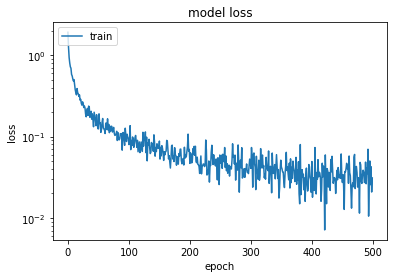

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

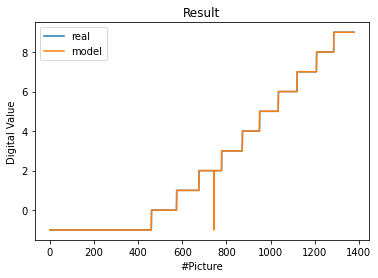

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp4h_n3y0h\assets


356604

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpomi98kun\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpomi98kun\assets


98512

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/2\4_nt7_20210625-205647.jpg 2 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.